In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("movies_ratings_clean.csv")
print("Shape:", df.shape)
print(df.head())

Shape: (32000204, 9)
   userId  movieId  rating  timestamp             datetime  \
0       1       17     4.0  944249077  1999-12-03 19:24:37   
1       1       25     1.0  944250228  1999-12-03 19:43:48   
2       1       29     2.0  943230976  1999-11-22 00:36:16   
3       1       30     5.0  944249077  1999-12-03 19:24:37   
4       1       32     5.0  943228858  1999-11-22 00:00:58   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres    year  \
0                           Drama|Romance  1995.0   
1                           Drama|Romance  1995.0   
2  Adventure|Drama|Fantasy|Mystery|Sci-Fi  1995.0   
3                             Crime|Drama  1995.0   
4   

In [29]:
df_sample = df.sample(n=100000, random_state=42)

print("Sample shape:", df_sample.shape)
print(df_sample.head())

Sample shape: (100000, 31)
          userId  movieId  rating           timestamp             datetime  \
10685861   66954      781     5.0 1996-12-18 21:29:37  1996-12-18 21:29:37   
1552723     9877      574     4.0 1999-12-18 05:40:14  1999-12-18 05:40:14   
6145184    38348     1088     2.0 2001-09-08 18:47:47  2001-09-08 18:47:47   
16268584  101952     2706     1.0 2008-02-15 12:12:45  2008-02-15 12:12:45   
22418634  140400   275079     3.5 2022-05-29 00:01:03  2022-05-29 00:01:03   

                                        title  \
10685861               Stealing Beauty (1996)   
1552723            Spanking the Monkey (1994)   
6145184                  Dirty Dancing (1987)   
16268584                  American Pie (1999)   
22418634  Chip 'n Dale: Rescue Rangers (2022)   

                                                     genres  year  \
10685861                                              Drama  1996   
1552723                                        Comedy|Drama  1999   
61

In [30]:
df_sample["user_count"] = df_sample.groupby("userId")["rating"].transform("count")
df_sample["user_mean"] = df_sample.groupby("userId")["rating"].transform("mean")
df_sample["user_std"]   = df_sample.groupby("userId")["rating"].transform("std")

df_sample["movie_count"] = df_sample.groupby("movieId")["rating"].transform("count")
df_sample["movie_mean"]  = df_sample.groupby("movieId")["rating"].transform("mean")
df_sample["movie_std"]   = df_sample.groupby("movieId")["rating"].transform("std")


df_sample["rating_minus_user_mean"]  = df_sample["rating"] - df_sample["user_mean"]
df_sample["rating_minus_movie_mean"] = df_sample["rating"] - df_sample["movie_mean"]

print("\nDataset after feature engineering (sample):")
print(df_sample.head())


Dataset after feature engineering (sample):
          userId  movieId  rating           timestamp             datetime  \
10685861   66954      781     5.0 1996-12-18 21:29:37  1996-12-18 21:29:37   
1552723     9877      574     4.0 1999-12-18 05:40:14  1999-12-18 05:40:14   
6145184    38348     1088     2.0 2001-09-08 18:47:47  2001-09-08 18:47:47   
16268584  101952     2706     1.0 2008-02-15 12:12:45  2008-02-15 12:12:45   
22418634  140400   275079     3.5 2022-05-29 00:01:03  2022-05-29 00:01:03   

                                        title  \
10685861               Stealing Beauty (1996)   
1552723            Spanking the Monkey (1994)   
6145184                  Dirty Dancing (1987)   
16268584                  American Pie (1999)   
22418634  Chip 'n Dale: Rescue Rangers (2022)   

                                                     genres  year  \
10685861                                              Drama  1996   
1552723                                        Comedy

In [33]:
features = [
    "rating",
    "user_mean","movie_mean",
    "rating_minus_user_mean","rating_minus_movie_mean"
]

X = df_sample[features].fillna(0).astype("float32")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X_scaled.shape)

Shape: (100000, 5)


In [36]:
iso = IsolationForest(n_estimators=150, contamination=0.01,
                      random_state=42, n_jobs=-1)
iso.fit(X_scaled)

df_sample["iso_score"] = iso.decision_function(X_scaled)
df_sample["iso_anom"] = (iso.predict(X_scaled) == -1).astype(int)

iso_count = df_sample["iso_anom"].sum()
iso_percent = round((iso_count / len(df_sample)) * 100, 2)

print(f"\nIsolation Forest anomalies detected: {iso_count} ({iso_percent}%)")


Isolation Forest anomalies detected: 999 (1.0%)


In [39]:
df_lof = df_sample.sample(n=20000, random_state=42).drop_duplicates(subset=features)
X_lof = scaler.fit_transform(df_lof[features])

lof = LocalOutlierFactor(n_neighbors=100, contamination=0.01, n_jobs=-1)
labels = lof.fit_predict(X_lof)

df_lof["lof_score"] = -lof.negative_outlier_factor_
df_lof["lof_anom"] = (labels == -1).astype(int)

lof_count = df_lof["lof_anom"].sum()
lof_percent = round((lof_count / len(df_lof)) * 100, 2)

print(f"LOF anomalies detected (20k sample): {lof_count} ({lof_percent}%)")

LOF anomalies detected (20k sample): 133 (1.0%)


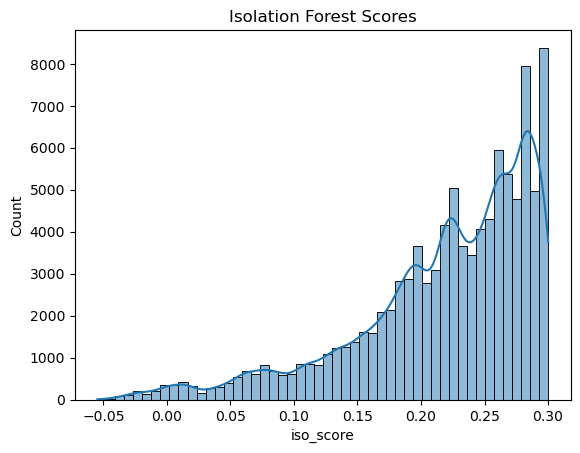

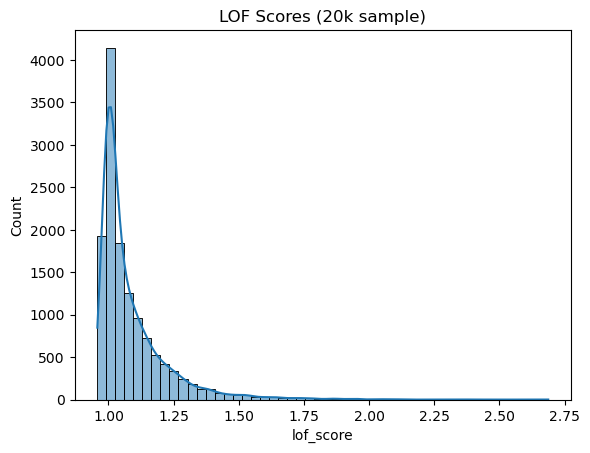

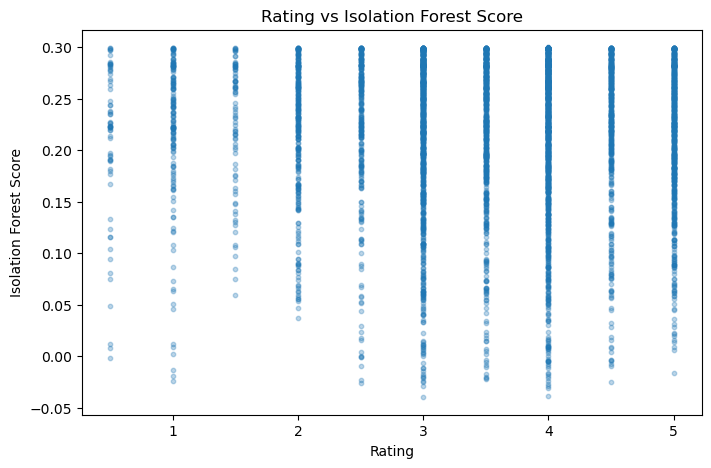

In [40]:
sns.histplot(df_sample["iso_score"], bins=50, kde=True)
plt.title("Isolation Forest Scores")
plt.show()

sns.histplot(df_lof["lof_score"], bins=50, kde=True)
plt.title("LOF Scores (20k sample)")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(df_sample["rating"].sample(5000), df_sample["iso_score"].sample(5000),
            alpha=0.3, s=10)
plt.xlabel("Rating")
plt.ylabel("Isolation Forest Score")
plt.title("Rating vs Isolation Forest Score")
plt.show()

In [41]:
df_sample.to_csv("movies_ratings_iso_anomalies.csv", index=False)
df_lof.to_csv("movies_ratings_lof_anomalies.csv", index=False)

print("\nSaved results:")
print("- movies_ratings_iso_anomalies.csv (Isolation Forest, 100k sample)")
print("- movies_ratings_lof_anomalies.csv (LOF, 20k subsample)")


Saved results:
- movies_ratings_iso_anomalies.csv (Isolation Forest, 100k sample)
- movies_ratings_lof_anomalies.csv (LOF, 20k subsample)


In [52]:
total_rows = 32000204  

iso_estimated = round((iso_percent / 100) * total_rows)
lof_estimated = round((lof_percent / 100) * total_rows)

print("Anomaly Detection Summary\n")

print(f"Sample Results:")
print(f"- Isolation Forest: {iso_count} anomalies out of {len(df_sample)} "
      f"({iso_percent}%)")
print(f"- LOF: {lof_count} anomalies out of {len(df_lof)} "
      f"({lof_percent}%)\n")

print(f"Estimated anomalies in FULL dataset (32,000,204 rows):")
print(f"- Isolation Forest: ~{iso_estimated:,} rows ({iso_percent}%)")
print(f"- LOF: ~{lof_estimated:,} rows ({lof_percent}%)")


Anomaly Detection Summary

Sample Results:
- Isolation Forest: 999 anomalies out of 100000 (1.0%)
- LOF: 133 anomalies out of 13288 (1.0%)

Estimated anomalies in FULL dataset (32,000,204 rows):
- Isolation Forest: ~320,002 rows (1.0%)
- LOF: ~320,002 rows (1.0%)
